In [1]:
#imports
%matplotlib inline
%load_ext autoreload
%autoreload 5
%autosave 15

import pandas as pd
import math
import scipy as sp
import numpy as np
import sklearn.cross_validation as cv
import sklearn.metrics as mt
import matplotlib.pyplot as plt


Autosaving every 15 seconds


In [2]:
# kernel and distance examples
def linear(dist): 
    return 1 - dist
def default(dist):
    return 1
def cosKernel(dist):
    return math.cos(dist * math.pi / 2)
def minkowskiDist(k):
    def newDist(a, b):
        res = 0
        for (name, value) in a.iteritems():
            res += math.fabs(value - b[name])**k
        return math.pow(res, 1 / k)
    return newDist
euclidDist = minkowskiDist(2)
# main classifier
class kNNClassifier:
    classColumn = 'clazz'
    trainData = None # samples with known classes
    k = None # number of nearest neighbours
    kernel = None # kernel
    distanceMeasure = None
    numberOfClasses = None
    
    
    def __init__(self, trainData, k = 5, kernel = linear, distanceMeasure = euclidDist, numberOfClasses = 2):
        self.trainData = trainData
        self.k = k
        self.kernel = kernel
        self.distanceMeasure = distanceMeasure
        self.numberOfClasses = numberOfClasses
        
    def computePoint(self, Point):
        dist = [[self.distanceMeasure(Point, sample.drop(self.classColumn)), 
                 sample[self.classColumn]] 
                for index, sample in self.trainData.iterrows()]
        sortedDist = sorted(dist)
        classValues = [0] * self.numberOfClasses
        for p in sortedDist[:self.k]:
            classValues[int(p[1])] += self.kernel(p[0] / sortedDist[self.k + 1][0])
        return classValues.index(max(classValues))
    
    def compute(self, testData):
        return [self.computePoint(x) for (index, x) in testData.iterrows()]

In [3]:
# Test classifier
data = pd.read_csv("chips.csv")
classifier = kNNClassifier(data, k = 23)
data2 = data.drop('clazz', axis = 1)#[1:2]
print(classifier.compute(data2))


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]


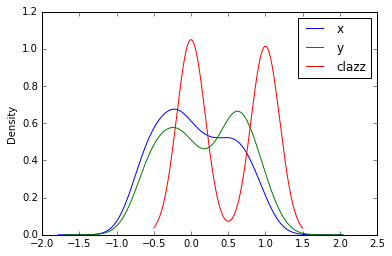

In [4]:
data = pd.read_csv("chips.csv")
data.plot(kind='kde')

In [5]:
data = pd.read_csv("chips.csv")
x1 = -0.2
y1 = 0.4
x2 = 0.35
y2 = 0
data['distToCenter'] = pd.Series([min((curP.x - x1)**2 + (curP.y - y1)**2, 
                                           (curP.x - x2)**2 + (curP.y - y2)**2) 
                               for index, curP in data.iterrows()], index=data.index)
maxD = max(data.distToCenter)
minD = min(data.distToCenter)
data['distToCenterNorm'] = pd.Series([(curP.distToCenter - minD) / (maxD - minD)
                               for index, curP in data.iterrows()], index=data.index)
data.drop(['x', 'y', 'distToCenter'], inplace = True, axis = 1)

In [6]:
data.describe()

,clazz,distToCenterNorm
count,118.000000,118.000000
mean,0.491525,0.358812
std,0.502060,0.222734
min,0.000000,0.000000
25%,0.000000,0.173395
50%,0.000000,0.360644
75%,1.000000,0.483464
max,1.000000,1.000000


In [107]:
k = 5
CV = cv.KFold(len(data), n_folds=k, shuffle=True, random_state=None)
score = 0.0
for traincv, testcv in CV:
    train = data.iloc[traincv]
    test = data.iloc[testcv]
    classifier = kNNClassifier(train, k = 7, kernel = cosKernel)
    score += mt.accuracy_score(classifier.compute(test.drop('clazz', axis=1)), test.clazz) / k
print(score)    

0.803985507246


In [105]:
#try default features
data2 = pd.read_csv("chips.csv")
k = 5
CV = cv.KFold(len(data), n_folds=k, shuffle=True, random_state=None)
score = 0.0
for traincv, testcv in CV:
    train = data.iloc[traincv]
    test = data.iloc[testcv]
    classifier = kNNClassifier(train, k = 3, kernel = cosKernel)
    score += mt.accuracy_score(classifier.compute(test.drop('clazz', axis=1)), test.clazz) / k
print(score)   

0.76268115942


/home/timur/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


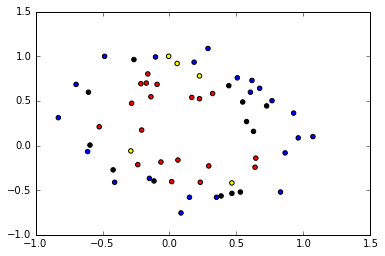

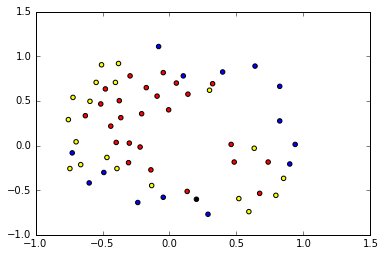

In [12]:
#Visualize 
data = pd.read_csv("chips.csv")
k = 2
CV = cv.KFold(len(data), n_folds=k, shuffle=True, random_state=None)
for traincv, testcv in CV:
    train = data.iloc[traincv]
    test = data.iloc[testcv]
    classifier = kNNClassifier(train, k = 7, kernel = cosKernel)
    test['predClazz'] = pd.Series(classifier.compute(test.drop('clazz', axis=1)), index=test.index)
    # false negative - black
    # false positive - yellow
    # true positive - red
    # true negative - blue
    col = ['BLack' if x.predClazz == 0 and x.clazz == 1 else
           'Yellow'if x.predClazz == 1 and x.clazz == 0 else
           'Red' if x.predClazz == 1 and x.clazz == 1 else
           'Blue' for i, x in test.iterrows()]
    plt.scatter(test.x, test.y, c=col)
    plt.show()

In [14]:
data = pd.read_csv("chips.csv")
data.describe()

,x,y,clazz
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646562,1.000000
max,1.070900,1.108900,1.000000


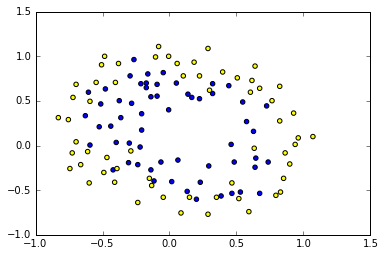

In [45]:
col = ['Yellow' if x == 0 else 'Blue' for x in data.clazz]
plt.scatter(data.x, data.y, c=col)
plt.show()

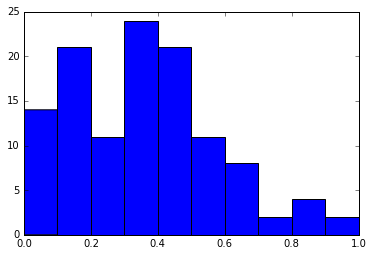

In [90]:
plt.hist(data.distToCenterNorm)
plt.show()

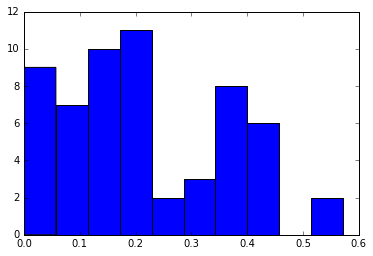

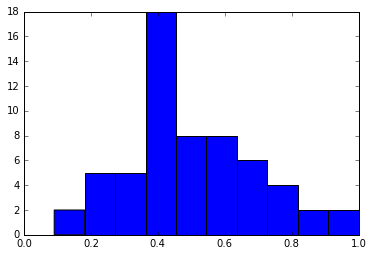

In [92]:
plt.hist(data[data.clazz == 1].distToCenterNorm)
plt.show()
plt.hist(data[data.clazz == 0].distToCenterNorm)
plt.show()